<a href="https://colab.research.google.com/github/wallacecarlis/data_science/blob/main/PROJETO_6_AVALIACAO_DE_RISCO_DE_CREDITO_XGBOOST_SGD_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

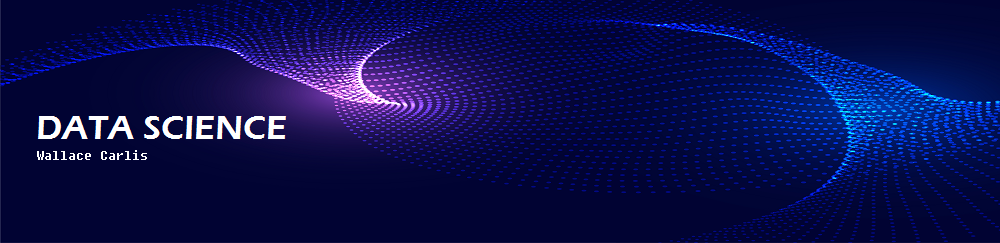

## Avaliação de Risco de Crédito com **XGBoost, SGD e LightGBM**.

#### **Risco de Crédito**, segundo o **[Wikipedia](https://pt.wikipedia.org/wiki/Risco_de_cr%C3%A9dito)**, é o **risco padrão** (**default**) em uma operação de crédito que surge quando o mutuário (**cliente**) não é capaz de honrar as dívidas compromissadas. E, em caso positivo, seu **não pagamento** afetará diretamente o balanço da instituição financeira. Mediante o cenário de avaliação se uma pessoa **irá ou não** saldar o crédito tomado, diversas soluções vêm sendo **desenvolvidas e aprimoradas** para tal finalidade, onde normalmente, um dos principais motivos de não pagamento é a **incapacidade financeira** por parte do cliente.

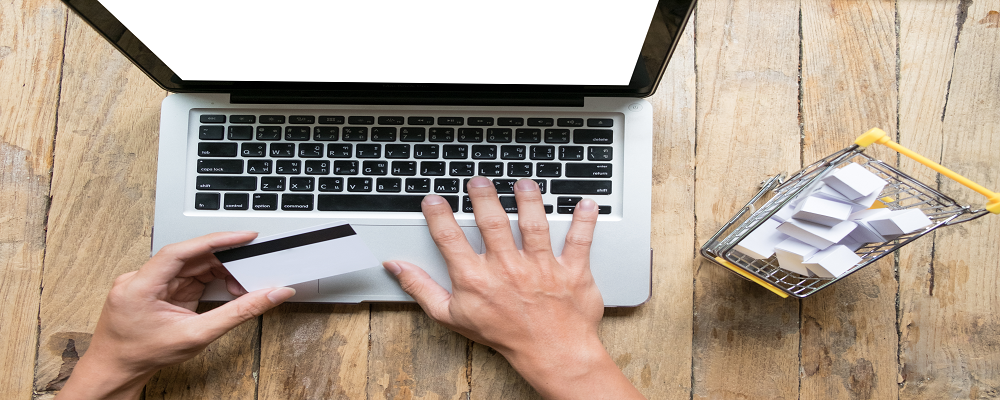

#### Devido a isso, bancos e fintechs cada vez mais têm utilizado modelos de **machine learning** no intuito de se prevenirem da **inadimplência** de seus clientes. O **[Nubank](https://nubank.com.br/sobre-nos/)** é uma dessas instituições, que inclusive disponibiliza uma **base de dados** de uma competição da própria instituição a fim de, tanto minimizar suas perdas pela **inadimplência**, quanto obviamente, descobrir talentos nessa área e potencializar seu time com tais contratações.

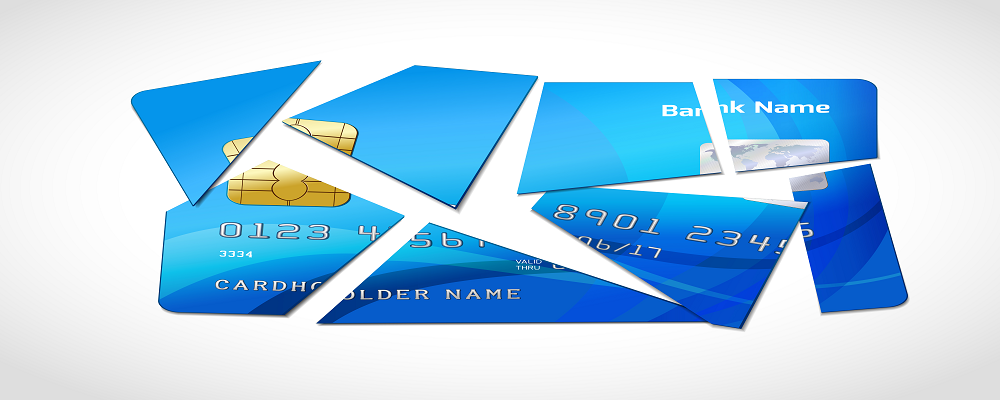

#### Portanto, o objetivo deste projeto será o da **criação de um modelo de machine learning** que verifique qual a **probabilidade de acerto** de um cliente **em potencial** não se tornar **inadimplente**, ou seja, normalmente em seu primeiro contato com a instituição, assim que ele solicita seu cartão **Nubank**.

#### Tecnicamente dois objetivos serão esperados:
* mitigação de perdas financeiras;
* diminuição dos falsos positivos.

#### Como padrão iremos importar as bibliotecas necessárias para análise, tratamento e visualização dos dados, balanceamento e padronização, criação dos modelos de machine learning, otimização dos parâmetros e visualização das métricas dos resultados.

In [ ]:
# 1 - Importando as bibliotecas

# Análise de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "svg"
plt.rcParams["font.family"] = "sans-serif"
import seaborn as sns

# Padronização, encoding, balanceamento e pré-processamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

# Divisão em treino e teste, validação cruzada
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Algoritmos de Machine Learning
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_score, classification_report

# Otimização dos hiperparâmetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Tratamento de warnings
from warnings import simplefilter
simplefilter(action = "ignore", category = FutureWarning)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# 2 - Acessando a base de dados
arquivo_1 = "https://raw.githubusercontent.com/wallacecarlis/arquivos_ml/refs/heads/main/avaliacao_risco_credito_1.csv"
arquivo_2 = "https://raw.githubusercontent.com/wallacecarlis/arquivos_ml/refs/heads/main/avaliacao_risco_credito_2.csv"
df_1 = pd.read_csv(arquivo_1)
df_2 = pd.read_csv(arquivo_2)
df = pd.concat([df_1, df_2], ignore_index = True)

# Calculando a utilização de memória do DataFrame
memory_usage = df.memory_usage(deep = True).sum() / (1024 ** 2)
print(f"Memória usada pelo DataFrame: {memory_usage.round(2)} MB")

Memória usada pelo DataFrame: 84.1 MB


In [ ]:
# 3 - Visualizando a quantidade de linhas e colunas
df.shape

(45000, 43)

#### Como verificado acima temos **45000** linhas e **43** colunas. Uma boa prática é a verificação dos nomes das colunas. Podemos realizar a verificação tanto com a propriedade **columns** quanto o método **info**. Este traz mais detalhes, como os tipos de dados e valores ausentes. Vamos inserir ainda um dicionário para as colunas.

In [ ]:
# 4 - Visualizando os nomes das colunas
df.columns

Index(['ids', 'target_default', 'score_1', 'score_2', 'score_3', 'score_4',
       'score_5', 'score_6', 'risk_rate', 'last_amount_borrowed',
       'last_borrowed_in_months', 'credit_limit', 'reason', 'income',
       'facebook_profile', 'state', 'zip', 'channel', 'job_name', 'real_state',
       'ok_since', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts',
       'n_issues', 'application_time_applied', 'application_time_in_funnel',
       'email', 'external_data_provider_credit_checks_last_2_year',
       'external_data_provider_credit_checks_last_month',
       'external_data_provider_credit_checks_last_year',
       'external_data_provider_email_seen_before',
       'external_data_provider_first_name',
       'external_data_provider_fraud_score', 'lat_lon', 'marketing_channel',
       'profile_phone_number', 'reported_income', 'shipping_state',
       'shipping_zip_code', 'profile_tags', 'user_agent', 'target_fraud'],
      dtype='object')

#### Dicionário de dados:

* **ids** - id do cliente;
* **target_default** - variável que indica se o cliente entrou em default ou não;
* **score_1** - score de classificação do cliente;
* **score_2** - score de classificação do cliente;
* **score_3** - score de classificação do cliente;
* **score_4** - score de classificação do cliente;
* **score_5** - score de classificação do cliente;
* **score_6** - score de classificação do cliente;
* **risk_rate** - taxa de risco;
* **last_amount_borrowed** - último valor emprestado;
* **last_borrowed_in_months** - quantidade de meses desde o último empréstimo;
* **credit_limit** - limite de crédito;
* **reason** - Razão;
* **income** - Renda;
* **facebook_profile** - possui facebook ou não;
* **state** - Estado;
* **zip** - CEP;
* **channel** - canal de contato;
* **job_name** - Profissão;
* **real_state** - valor criptografado;
* **ok_since** - OK desde;
* **n_bankruptcies** - Quebra de contrato;
* **n_defaulted_loans** - Empréstimos inadimplentes;
* **n_accounts** - Quantidade de contas;
* **n_issues** - Quantidade de emissões;
* **application_time_applied** - Tempo de aplicação aplicado;
* **application_time_in_funnel** - Tempo de aplicação no funil;
* **email** - Provedor de E-mail;
* **external_data_provider_credit_checks_last_2_year** - Verificações de crédito nos últimos 2 anos;
* **external_data_provider_credit_checks_last_month** - Verificações de crédito no último mes;
* **external_data_provider_credit_checks_last_year** - Verificações de crédito no último ano;
* **external_data_provider_email_seen_before** - email do provedor de dados externo visto antes;
* **external_data_provider_first_name** - Primeiro nome no provedor;
* **external_data_provider_fraud_score** - pontuação de fraude do provedor de dados externo;
* **lat_lon** - Latitude e Longitude de localização;
* **marketing_channel** - Canal de contato;
* **profile_phone_number** - Número de telefone;
* **reported_income** - Salário informado;
* **shipping_state** - Estado de compra;
* **shipping_zip_code** - CEP da compra;
* **profile_tags** - Tags;
* **user_agent** - Navegador utilizado;
* **target_fraud** - variável target para indicação de fraude.

In [ ]:
# 5 - Visualizando as principais informações das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

#### Podemos já de início observar na saída do método **info** acima que algumas colunas estão com os tipos de dados como **object** quando deveriam ser numéricos (**score1** e **score2**), uma vez que as demais colunas **score** estão com o tipo **float**. Vamos aprofundar a compreensão com os métodos **head** e **describe**.

In [ ]:
# 6 - Visualização das primeiras linhas
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


#### Além da observação das colunas **score1** e **score2** como **object** com o **info**, pudemos verificar com o **head** que a coluna **ids** traz apenas a informação de identificação do cliente, que a coluna **target_default** é a **variável alvo**, e que a última coluna, **target_fraud**, poderia ser utilizada para a **previsão de fraudes**. No caso, não será nosso objeto de estudo neste momento.

#### Outras colunas apresentam algum tipo de codificação, como **reason, state, zip, channel, job_name** e **real_state**. **Profile_tags** aparentemente contém um **dicionário** com tags atribuídas a cada cliente. Além disso, a coluna **lat_lon** está em formato **object** contendo uma **tupla** com as coordenadas de latitude e longitude.

In [ ]:
# 7 - Verificando o resumo estatístico
df.describe().round()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,...,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.0,45000.0,45000.0,45000.0,44438.0,15044.0,15044.0,31200.0,44438.0,18455.0,...,44438.0,33456.0,45000.0,22372.0,45000.0,29876.0,42767.0,45000.0,45000.0,45000.0
mean,348.0,100.0,1.0,100.0,0.0,13782.0,42.0,34382.0,71607.0,35.0,...,11.0,11.0,248.0,0.0,2.0,1.0,13.0,500.0,inf,33924.0
std,110.0,3.0,0.0,10.0,0.0,8078.0,10.0,36587.0,51859.0,22.0,...,5.0,5.0,146.0,0.0,1.0,0.0,127.0,288.0,NaN,12692.0
min,0.0,86.0,0.0,61.0,0.0,1005.0,36.0,0.0,4821.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,0.0,403.0,12001.0
25%,270.0,98.0,0.0,93.0,0.0,7520.0,36.0,10000.0,45011.0,17.0,...,7.0,8.0,120.0,0.0,1.0,0.0,11.0,252.0,50948.0,22937.0
50%,340.0,100.0,1.0,100.0,0.0,12023.0,36.0,25647.0,61267.0,32.0,...,10.0,10.0,248.0,0.0,2.0,1.0,27.0,503.0,101779.0,33896.0
75%,420.0,102.0,1.0,107.0,0.0,19220.0,36.0,47087.0,86019.0,50.0,...,13.0,14.0,375.0,0.0,2.0,1.0,43.0,747.0,151337.0,44910.0
max,990.0,114.0,1.0,142.0,1.0,35060.0,60.0,448269.0,5000028.0,141.0,...,49.0,49.0,500.0,0.0,3.0,1.0,59.0,1000.0,inf,56000.0


#### Com a visualização do **describe** pudemos observar no resumo estatístico que algumas colunas apresentam valores mínimos **zerados**, inclusive a coluna **external_data_provider_credit_checks_last_2_year**, com todas as saídas da métrica zeradas. Um valor além de **negativo, altíssimo** para a coluna **external_data_provider_email_seen_before** (**-999**). E a própria coluna **reported_income** com preenchimento diverso de valores numéricos (**inf**). Visualizaremos como se comporta o **boxplot** da coluna **external_data_provider_email_seen_before**.

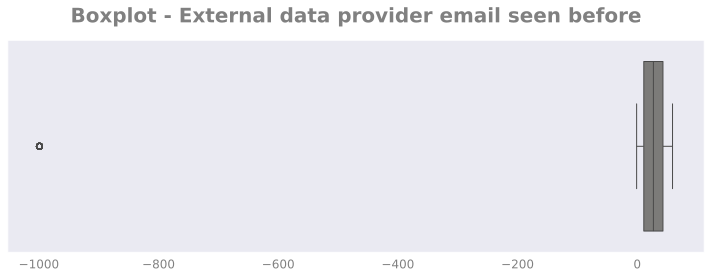

In [ ]:
# 8 - Boxplot da coluna external_data_provider_email_seen_before"
sns.set_style("dark")
fig, ax = plt.subplots(figsize = (10, 4))
ax = sns.boxplot(df["external_data_provider_email_seen_before"], orient = "h", palette = "cividis")
ax.set_title("Boxplot - External data provider email seen before", fontsize = 20,
             color = "grey", fontweight = "bold", pad = 18)
ax.set_xlabel("")
ax.tick_params(axis = "x", labelsize = 12, labelcolor = "grey")
plt.tight_layout()

#### Nitidamente um valor **altamente negativo** interfere na compreensão dos valores da coluna **external_data_provider_email_seen_before** no **boxplot** acima. Deveremos tratá-lo.

#### Outra análise após a verificação acima das colunas que iremos tratar será uma **nova observação** sobre a **quantidade de valores ausentes**, ainda que a função **info()** já tenha nos apresentado essa descrição por coluna. Sendo assim, veremos agora por **quantidade**.

In [ ]:
# 9 - Verificando os valores NaN por coluna
df.isnull().sum().sort_values(ascending = False)

,0
target_fraud,43478
last_amount_borrowed,29956
last_borrowed_in_months,29956
ok_since,26545
external_data_provider_credit_checks_last_2_year,22628
external_data_provider_credit_checks_last_year,15124
credit_limit,13800
n_issues,11544
facebook_profile,4458
marketing_channel,3578


#### Lembrando que a base de dados possui **45000** linhas podemos verificar que diversas colunas possuem dados ausentes. Como, por exemplo:
* target_fraud - 43478 (**96%** de dados ausentes);
* last_amount_borrowed - 29956 (**66%**);
* last_borrowed_in_months - 29956 (**66%**);
* ok_since - 26545 (**59%**);
* external_data_provider_credit_checks_last_2_year - 22628 (**50%**);
* external_data_provider_credit_checks_last_year - 15124 (**34%**);
* credit_limit - 13800 (**30%**);
* n_issues - 11544 (**26%**);
* facebook_profile - 4458 (**10%**);
* marketing_channel - 3578 (**8%**);
* job_name - 3336 (**7%**);
* target_default - 3259 (**7%**).

#### À partir dos resultados acima podemos excluir a coluna **target_fraud** uma vez que não faz parte do escopo deste projeto. As demais colunas serão avaliadas **caso a caso** com suas observações mais assertivas, como por exemplo, os **valores únicos** por coluna.

In [ ]:
# 10 - Verificando os valores únicos por coluna
df.nunique().sort_values()

,0
external_data_provider_credit_checks_last_2_year,1
channel,1
target_fraud,2
target_default,2
external_data_provider_credit_checks_last_year,2
facebook_profile,2
last_borrowed_in_months,2
external_data_provider_credit_checks_last_month,4
n_defaulted_loans,5
real_state,5


#### Uma observação importante será a visualização da quantidade de clientes inadimplentes da variável alvo **target_default**.

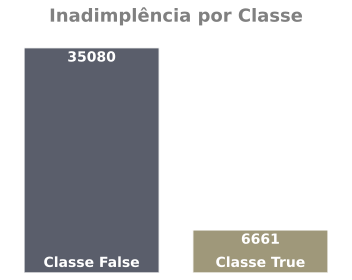

In [ ]:
# 11 - Visualizando a quantidade de clientes inadimplentes
sns.set_style("dark")
fig, ax = plt.subplots(figsize = (5, 4))
barras = sns.countplot(x = "target_default", data = df, palette = "cividis", ax = ax)
ax.set_title("Inadimplência por Classe", color = "grey",
             fontsize = 18, fontweight = "bold", pad = 15)

for i in barras.patches:
  ax.annotate(int(i.get_height()),
              xy = (i.get_x() + (i.get_width() / 2),
                    i.get_height() - (i.get_width() * 600)),
                    color = "white", fontweight = "bold",
                    ha = "center", va = "top",
                    fontsize = 14)

for i, (nome, valor) in enumerate(zip(df.target_default.value_counts().index,
                                     df.target_default.value_counts().values)):
  ax.text(i, valor - valor + 1500, f"Classe {nome}", ha = "center", color = "white",
          fontsize = 14, fontweight = "bold", va = "center")

ax.axis("off")
plt.tight_layout()

#### Percebemos, obviamente, um resultado desbalanceado. Faz sentido apenas uma parte dos clientes serem classificados como **inadimplentes**. Contudo, precisaremos balancear no momento de gerarmos os modelos de **machine learning**.

#### Vamos visualizar a **distribuição** dos valores da coluna de taxa de risco **risk_rate**.

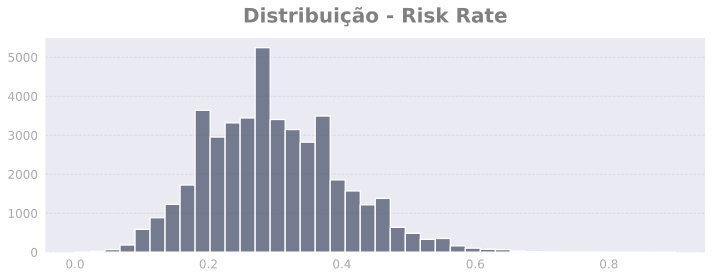

In [ ]:
# 12 - Visualização da distribuição da coluna risk_rate
sns.set_style("dark")
fig, ax = plt.subplots(figsize = (10, 4))
bins = 40
ax = sns.histplot(df["risk_rate"], lw = 5, bins = bins, color = "#4c556c")
ax.set_title("Distribuição - Risk Rate", fontsize = 20, color = "grey",
             fontweight = "bold", pad = 15)
ax.set_ylabel("")
ax.tick_params(axis = "y", labelsize = 12, labelcolor = "darkgrey")
ax.set_xlabel("")
ax.tick_params(axis = "x", labelsize = 12, labelcolor = "darkgrey")
ax.grid(True, axis = "y", linestyle = "--", color = "darkgrey", alpha = 0.3)
plt.tight_layout()

#### A visualização acima traz praticamente um **formato** de uma distribuição **normal** para a coluna de **taxa de risco**. Para iniciar os **tratamentos** nas colunas que iremos utilizar começaremos com uma **cópia** da base de dados.

In [ ]:
# 13 - Gerando uma cópia da base de dados
df_clean = df.copy()

#### Excluiremos algumas colunas que não iremos trabalhar, de acordo com o **objetivo** que definimos. No caso as colunas excluídas serão:

* "ids"
* "target_fraud"
* "external_data_provider_credit_checks_last_2_year"
* "channel"
* "reason"
* "zip"
* "job_name"
* "external_data_provider_first_name"
* "lat_lon"
* "shipping_zip_code"
* "user_agent"
* "profile_tags"
* "application_time_applied"
* "email"
* "marketing_channel"
* "profile_phone_number"
* "shipping_state"

In [ ]:
# 14 - Excluindo as colunas que não iremos trabalhar:
df_clean.drop(labels=['ids', 'target_fraud', 'external_data_provider_credit_checks_last_2_year',
                      'channel','reason', 'zip', 'job_name', 'external_data_provider_first_name',
                      'lat_lon', 'shipping_zip_code', 'user_agent', 'profile_tags','application_time_applied',
                      'email', 'marketing_channel', 'profile_phone_number', 'shipping_state'], axis=1, inplace=True)

#### Uma vez realizadas as exclusões, vamos visualizar as **colunas** que de fato iremos trabalhar visando nosso objetivo de obter a **probabilidade** de acerto de um cliente em potencial se tornar **inadimplente**.

In [ ]:
# 15 - Visualizando as colunas que iremos trabalhar
df_clean.columns

Index(['target_default', 'score_1', 'score_2', 'score_3', 'score_4', 'score_5',
       'score_6', 'risk_rate', 'last_amount_borrowed',
       'last_borrowed_in_months', 'credit_limit', 'income', 'facebook_profile',
       'state', 'real_state', 'ok_since', 'n_bankruptcies',
       'n_defaulted_loans', 'n_accounts', 'n_issues',
       'application_time_in_funnel',
       'external_data_provider_credit_checks_last_month',
       'external_data_provider_credit_checks_last_year',
       'external_data_provider_email_seen_before',
       'external_data_provider_fraud_score', 'reported_income'],
      dtype='object')

#### Precisamos alterar os dados **inf** da coluna **reported_income** para valores **nan**. Utilizaremos o método **replace()**.

In [ ]:
# 16 - Alterando os dados inf da coluna reported_income para valores nan
df_clean.reported_income = df_clean.reported_income.replace(np.inf, np.nan)

#### Trataremos o valor **-999** da coluna **external_data_provider_email_seen_before** substituindo-o também por valor **nan**. Utilizaremos a função **loc**.

In [ ]:
# 17 - Tratando os valores -999 na coluna external_data_provider_email_seen_before
df_clean.loc[df_clean["external_data_provider_email_seen_before"] == -999.0, "external_data_provider_email_seen_before"] = np.nan

#### Podemos retornar ao boxplot da coluna **external_data_provider_email_seen_before** para visualização após o devido tratamento acima.

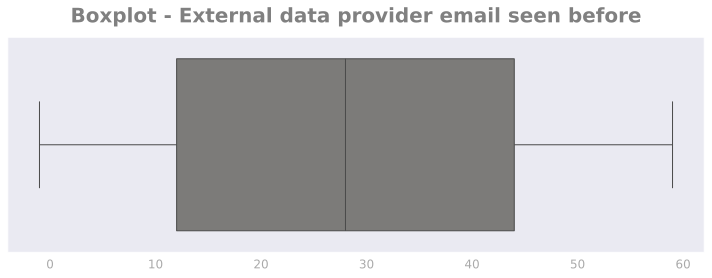

In [ ]:
# 18 - Boxplot da coluna external_data_provider_email_seen_before após a atualização dos dados
sns.set_style("dark")
fig, ax = plt.subplots(figsize = (10, 4))
ax = sns.boxplot(df_clean["external_data_provider_email_seen_before"], palette = "cividis", orient = "h")
ax.set_title("Boxplot - External data provider email seen before", fontsize = 20, color = "grey",
             pad = 15, fontweight = "bold")
ax.set_xlabel("")
ax.tick_params(axis = "x", labelsize = 12, labelcolor = "darkgrey")
plt.tight_layout()

#### Conforme esperado, a exclusão do **valor negativo** (**-999**) da coluna **external_data_provider_email_seen_before** nos traz uma visualização bem mais assertiva dos valores com a plotagem do **box**. Já para a coluna alvo, **target_default**, excluiremos as **linhas** onde os valores são **nan**. Utilizaremos o método **dropna**.

In [ ]:
# 19 - Excluindo as linhas com valores NaN na coluna alvo target_default
df_clean.dropna(subset = ["target_default"], inplace = True)

#### Para melhorar a assertividade nos tratamentos podemos ainda separar os dados em **numéricos** e **categóricos**. Utilizaremos o método **select_dtypes** para isso. Verificaremos também valores **NaN** para algumas colunas.

In [ ]:
# 20 - Criando variáveis para dados numéricos e categóricos
numerico = df_clean.select_dtypes(exclude = "object").columns
categorico = df_clean.select_dtypes(include = "object").columns

In [ ]:
# 21 - Verificando a quantidade de valores NaN nas seguintes colunas:
print(df_clean["last_borrowed_in_months"].isnull().sum())
print(df_clean["last_amount_borrowed"].isnull().sum())
print(df_clean["n_issues"].isnull().sum())

27608
27608
10923


#### Substituiremos os valores **NaN** por **zero** (**0**) nas colunas **numéricas**.

In [ ]:
# 22 - Substituindo valores NaN por zero
df_clean.last_amount_borrowed.fillna(value = 0, inplace = True)
df_clean.last_borrowed_in_months.fillna(value = 0, inplace = True)
df_clean.n_issues.fillna(value = 0, inplace = True)

#### Trataremos as variáveis **numéricas** inserindo a **mediana** nos valores **NaN** com o método **fillna**.

In [ ]:
# 23 - Preenchendo com a mediana nos valores NaN das variáveis numéricas
df_clean.loc[:, numerico] = df_clean.loc[:, numerico].fillna(df_clean.loc[:, numerico].median())

#### Já para as variáveis **categóricas** inseriremos nos valores **nan** os valores **mais frequentes**.

In [ ]:
# 24 - Preenchendo com a moda nos valores NaN para as variáveis categóricas
df_clean.loc[:, categorico] = df_clean.loc[:, categorico].fillna(df_clean.loc[:, categorico].mode().iloc[0])

#### Após os tratamentos acima vamos verificar se ainda existem valores **ausentes/nulos** nas colunas:

In [ ]:
# 25 - Verificando a existência de valores nulos
df_clean.isnull().sum()

,0
target_default,0
score_1,0
score_2,0
score_3,0
score_4,0
score_5,0
score_6,0
risk_rate,0
last_amount_borrowed,0
last_borrowed_in_months,0


#### Uma vez que os valores **ausentes** foram tratados vamos criar uma nova **cópia da base de dados** e iniciar a separação da base de dados em **treino, validação e teste**. Isso se faz necessário para evitar o **vazamento de dados** (data leakage).

In [ ]:
# 26 - Gerando uma nova cópia da base de dados
df_not_null = df_clean.copy()

In [ ]:
# 27 - Separando a base total em treino e teste
train_ratio = 0.8
train_size = int(len(df_not_null) * train_ratio)
df_shuffled = df_not_null.sample(frac = 1, random_state = 42)
df_train = df_shuffled[: train_size]
df_test = df_shuffled[train_size :]

In [ ]:
# 28 - Definindo X e y nas bases de treino e teste
X = df_train.drop(columns = ["target_default"])
y = df_train.target_default

X_test = df_test.drop(columns = ["target_default"])
y_test = df_test.target_default

In [ ]:
# 29 - Separando a base de treino em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2,
                                                      stratify = y,
                                                      random_state = 42)

#### Uma vez que a base está separada em **treino, validação e teste**, podemos separar as colunas por tipo de dados, **numéricos** e **categóricos**. Além disso, o primeiro tratamento será com o **label encoder**, de formar individual, em todas as variáveis da base. Em seguida, serão os passos de **padronização, balanceamento e treino** do algoritmo.

In [ ]:
# 30 - Separando as variáveis em colunas numéricas e categóricas
colunas_numericas = X.select_dtypes(exclude = "object").columns
colunas_categoricas = X.select_dtypes(exclude = "object").columns

#### Aplicando o **label encoder**. Para o treino **fit_transform**, já para validação e teste somente **transform**.

In [ ]:
# 31 - Aplicando o Label Encoder em todas as variáveis da base de dados
le_target = LabelEncoder()
y_train = le_target.fit_transform(y_train)
y_valid = le_target.transform(y_valid)
y_test = le_target.transform(y_test)

label_encoders = {}
for col in colunas_categoricas:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    categorias_conhecidas = set(le.classes_)
    X_valid[col] = X_valid[col].apply(lambda x: le.transform([x])[0] if x in categorias_conhecidas else -1)
    X_test[col] = X_test[col].apply(lambda x: le.transform([x])[0] if x in categorias_conhecidas else -1)
    label_encoders[col] = le

#### Aplicando a **padronização** nas **colunas numéricas** e o **encoding** nas **colunas categóricas**.

In [ ]:
# 32 - Aplicando Standard Scaler e One Hot Encoder no Column Transform
preprocessor = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), colunas_numericas),
        ("cat", OneHotEncoder(handle_unknown = "ignore"), colunas_categoricas)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test  = preprocessor.transform(X_test)

#### Aplicando o **balanceamento** nos dados de **treino**.

In [ ]:
# 33 - Aplicando o balanceamento com SMOTE nos dados de treino
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### Selecionando os **algoritmos** de machine learning.

In [ ]:
# 34 - Instanciando os modelos de machine learning
model_xgb = XGBClassifier(random_state = 42)
model_sgd = SGDClassifier(random_state = 42)
model_lgbm = LGBMClassifier(random_state = 42)

#### Criando uma função para aplicação da **validação cruzada** para o **modelo** escolhido.

In [ ]:
# 34 - Modelo e validação cruzada
def select_model(modelo):
  score_f1 = cross_val_score(modelo,
                                    X_train_smote,
                                    y_train_smote,
                                    cv = 10,
                                    scoring = "f1")
  return score_f1

#### Verificando o **score f1** por modelo.

In [ ]:
# 35 - Score f1 do XGBoost
score_f1_xgb = select_model(model_xgb)
print(score_f1_xgb.mean())

0.8167124468231748


In [ ]:
# 36 - Score f1 do SGD
score_f1_sgd = select_model(model_sgd)
print(score_f1_sgd.mean())

0.9886322160479043


In [ ]:
# 37 - Score f1 do LGBM
score_f1_lgbm = select_model(model_lgbm)
print(score_f1_lgbm.mean())

[LightGBM] [Info] Number of positive: 20200, number of negative: 20199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.633744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89389
[LightGBM] [Info] Number of data points in the train set: 40399, number of used features: 2571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500012 -> initscore=0.000050
[LightGBM] [Info] Start training from score 0.000050
[LightGBM] [Info] Number of positive: 20200, number of negative: 20199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.603160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88606
[LightGBM] [Info] Number of data points in the train set: 40399, number of used features: 2534
[LightGBM] [In

#### Após a verificação dos **score f1**, vamos criar uma função para a aplicar o treinamento na base de **validação** por modelo, e uma função para verificação das **métricas**.

In [ ]:
# 38 - Treino e validação
def train_validation(modelo):
  modelo.fit(X_train_smote, y_train_smote)
  y_pred = modelo.predict(X_valid)
  return y_pred

# Aplicando a função de treino e validação no modelo
y_pred_xgb = train_validation(model_xgb)
y_pred_sgd = train_validation(model_sgd)
y_pred_lgbm = train_validation(model_lgbm)

[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.192353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91174
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 2709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# 39 - Criando uma função para visualizar as métricas por modelo
def metrics(y_predicao, score_f1):
  acc = accuracy_score(y_valid, y_predicao)
  f1 = f1_score(y_valid, y_predicao)
  auc = roc_auc_score(y_valid, y_predicao)
  precision = precision_score(y_valid, y_predicao)
  print(f"F1 (cross-validation): {score_f1.mean():.4f}")
  print(f"Acurácia: {acc:.4f}")
  print(f"F1-Score: {f1:.4f}")
  print(f"AUC-ROC:  {auc:.4f}")
  print(f"Precisão: {precision:.4f}")

#### Verificação das **métricas** por modelo.

In [ ]:
# 40 - Verificação das métricas do XGBoost
metricas_xgb = metrics(y_pred_xgb, score_f1_xgb)
metricas_xgb

F1 (cross-validation): 0.8167
Acurácia: 0.8272
F1-Score: 0.0870
AUC-ROC:  0.5131
Precisão: 0.2792


In [ ]:
# 41 - Verificação das métricas do SGD
metricas_sgd = metrics(y_pred_sgd, score_f1_sgd)
metricas_sgd

F1 (cross-validation): 0.9886
Acurácia: 0.8278
F1-Score: 0.0959
AUC-ROC:  0.5158
Precisão: 0.2976


In [ ]:
# 42 - Verificação das métricas do LGBM
metricas_lgbm = metrics(y_pred_lgbm, score_f1_lgbm)
metricas_lgbm

F1 (cross-validation): 0.8159
Acurácia: 0.8402
F1-Score: 0.0130
AUC-ROC:  0.5027
Precisão: 0.5000


### Após a verificação da **validação cruzada**, vamos verificar cada **matriz de confusão** com suas **métricas**.

In [ ]:
# 43 - Gerando a matriz de confusão para cada modelo
def plot_matriz_confusao(y_predicao, algoritmo):
  cm = confusion_matrix(y_valid, y_predicao, normalize = "true")

  fig, ax = plt.subplots(figsize = (10, 5), dpi = 200)
  ax = sns.heatmap(cm, annot = True, fmt = ".2f", cmap = "Blues",
                    xticklabels=["Negativo", "Positivo"],
                    yticklabels=["Negativo", "Positivo"])
  ax.set_title(f"Matriz de Confusão - {algoritmo}", color = "grey", fontsize = 24, fontweight = "bold", pad = 18)
  ax.set_xlabel("Predições", color = "darkgrey", fontsize = 14, fontweight = "semibold")
  ax.tick_params(axis = "x", labelsize = 12, colors = "grey")
  ax.set_ylabel("Real", color = "darkgrey", fontsize = 14, fontweight = "semibold")
  ax.tick_params(axis = "y", labelsize = 12, colors = "grey")
  plt.tight_layout()
  print(classification_report(y_valid, y_predicao))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      5612
           1       0.28      0.05      0.09      1067

    accuracy                           0.83      6679
   macro avg       0.56      0.51      0.50      6679
weighted avg       0.75      0.83      0.77      6679



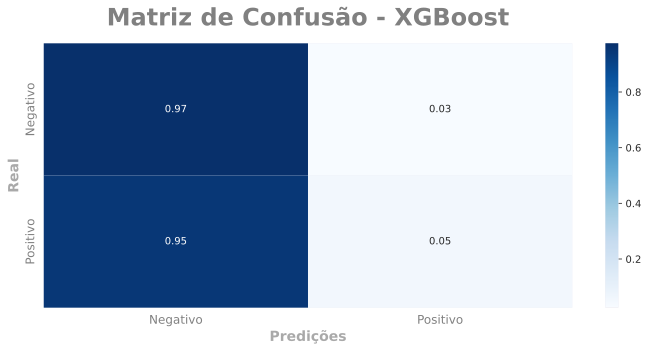

In [ ]:
# 44 - Matriz de confusão - XGBoost
plot_matriz_confusao(y_pred_xgb, "XGBoost")

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      5612
           1       0.30      0.06      0.10      1067

    accuracy                           0.83      6679
   macro avg       0.57      0.52      0.50      6679
weighted avg       0.76      0.83      0.78      6679



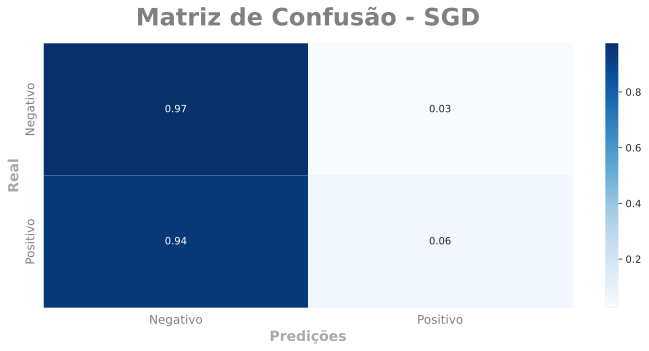

In [ ]:
# 45 - Matriz de confusão - SGD
plot_matriz_confusao(y_pred_sgd, "SGD")

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      5612
           1       0.50      0.01      0.01      1067

    accuracy                           0.84      6679
   macro avg       0.67      0.50      0.46      6679
weighted avg       0.79      0.84      0.77      6679



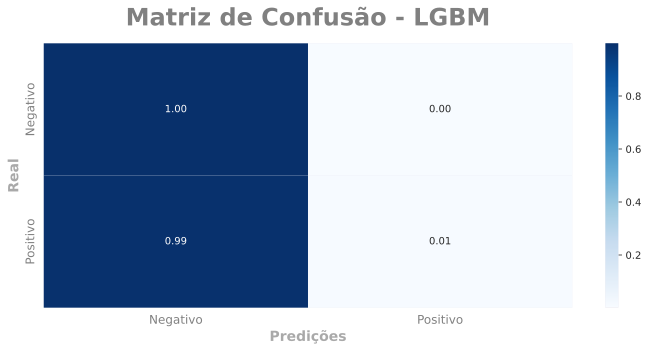

In [ ]:
# 46 - Matriz de confusão - LGBM
plot_matriz_confusao(y_pred_lgbm, "LGBM")

#### Uma vez que temos nosso treinado, podemos verificar quais são os melhores **hiperparâmetros** do melhor modelo.

In [ ]:
# 47 - Configurando o parâmetro n_estimators
param_grid_1 = {
    "n_estimators" : [50, 100, 150, 200]
}

grid_search_1 = GridSearchCV(
    model_lgbm,
    param_grid_1,
    cv = 5,
    scoring = "f1",
    n_jobs =-1,
    verbose = 2
)

grid_search_1.fit(X_train_smote, y_train_smote)
best_n_estimators = grid_search_1.best_params_["n_estimators"]
print(f"Melhor n_estimators: {best_n_estimators}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.735459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91174
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 2709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhor n_estimators: 100


In [ ]:
# 48 - Configurando o parâmetro max_depth
param_grid_2 = {
    "max_depth" : [5, 10, 20, 30]
}

model_lgbm.set_params(n_estimators = best_n_estimators)

grid_search_2 = GridSearchCV(
    model_lgbm,
    param_grid_2,
    cv = 5,
    scoring = "f1",
    n_jobs=-1,
    verbose = 2
)

grid_search_2.fit(X_train_smote, y_train_smote)
best_max_depth = grid_search_2.best_params_["max_depth"]
print(f"Melhor max_depth: {best_max_depth}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.716719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91174
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 2709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhor max_depth: 30


In [ ]:
# 49 - Configurando o parâmetro learning rate
param_grid_3 = {
    "learning_rate" : [0.01, 0.05, 0.1, 0.2, 0.3]
}

model_lgbm.set_params(max_depth = best_max_depth)

grid_search_3 = GridSearchCV(
    model_lgbm,
    param_grid_3,
    cv = 5,
    scoring = "f1",
    n_jobs =-1,
    verbose = 2)

grid_search_3.fit(X_train_smote, y_train_smote)
best_learning_rate = grid_search_3.best_params_["learning_rate"]
print(f"Melhor learning_rate: {best_learning_rate}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.740039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91174
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 2709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhor learning_rate: 0.1


In [ ]:
# 50 - Configurando o parâmetro num_leaves
param_grid_4 = {
    "num_leaves": [31, 63, 127]
}

model_lgbm.set_params(learning_rate = best_learning_rate)

grid_search_4 = GridSearchCV(
    model_lgbm,
    param_grid_4,
    cv = 5,
    scoring = "f1",
    n_jobs=-1,
    verbose = 2
)

grid_search_4.fit(X_train_smote, y_train_smote)
best_num_leaves = grid_search_4.best_params_["num_leaves"]
print(f"Melhor num_leaves: {best_num_leaves}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.345645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91174
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 2709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhor num_leaves: 31


In [ ]:
# 51 - Configurando o parâmetro min_child_samples
param_grid_5 = {
    "min_child_samples": [10, 20, 30]
}

model_lgbm.set_params(num_leaves = best_num_leaves)

grid_search_5 = GridSearchCV(
    model_lgbm,
    param_grid_5,
    cv = 5,
    scoring = "f1",
    n_jobs=-1,
    verbose = 2
)

grid_search_5.fit(X_train_smote, y_train_smote)
best_min_child_samples = grid_search_5.best_params_["min_child_samples"]
print(f"Melhor min_child_samples: {best_min_child_samples}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.629026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147715
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 12755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhor min_child_samples: 10


In [ ]:
# 52 - Configurando o parâmetro reg_alpha
param_grid_6 = {
    "reg_alpha": [0, 0.1, 0.5, 1]
}

model_lgbm.set_params(min_child_samples = best_min_child_samples)

grid_search_6 = GridSearchCV(
    model_lgbm,
    param_grid_6,
    cv = 5,
    scoring = "f1",
    n_jobs=-1,
    verbose = 2
)

grid_search_6.fit(X_train_smote, y_train_smote)
best_reg_alpha = grid_search_6.best_params_["reg_alpha"]
print(f"Melhor reg_alpha: {best_reg_alpha}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.607355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147715
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 12755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhor reg_alpha: 1


In [ ]:
# 53 - Configurando o parâmetro reg_alpha
param_grid_7 = {
    "reg_lambda": [0, 0.1, 0.5, 1]
}

model_lgbm.set_params(reg_alpha = best_reg_alpha)

grid_search_7 = GridSearchCV(
    model_lgbm,
    param_grid_7,
    cv = 5,
    scoring = "f1",
    n_jobs=-1,
    verbose = 2
)

grid_search_7.fit(X_train_smote, y_train_smote)
best_reg_lambda = grid_search_7.best_params_["reg_lambda"]
print(f"Melhor reg_lambda: {best_reg_lambda}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.333274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147715
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 12755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhor reg_lambda: 0


In [ ]:
# 54 - Configurando o parâmetro boosting_type
param_grid_8 = {
    "boosting_type": ["gbdt", "dart", "goss"]
}

model_lgbm.set_params(reg_lambda = best_reg_lambda)

grid_search_8 = GridSearchCV(
    model_lgbm,
    param_grid_8,
    cv = 5,
    scoring = "f1",
    n_jobs=-1,
    verbose = 2
)

grid_search_8.fit(X_train_smote, y_train_smote)
best_boosting_type = grid_search_8.best_params_["boosting_type"]
print(f"Melhor boosting_type: {best_boosting_type}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.759715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147715
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 12755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhor boosting_type: gbdt


In [ ]:
# 55 - Configurando o parâmetro scale_pos_weight
param_grid_9 = {
    "scale_pos_weight": [1, 2, 3, 5]
}

model_lgbm.set_params(boosting_type = best_boosting_type)

grid_search_9 = GridSearchCV(
    model_lgbm,
    param_grid_9,
    cv = 5,
    scoring = "f1",
    n_jobs=-1,
    verbose = 2
)

grid_search_9.fit(X_train_smote, y_train_smote)
best_scale_pos_weight = grid_search_9.best_params_["scale_pos_weight"]
print(f"Melhor scale_pos_weight: {best_scale_pos_weight}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.867237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147715
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 12755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhor scale_pos_weight: 1


In [ ]:
# 56 - Configurando o modelo final
model_lgbm_final = LGBMClassifier(
    n_estimators      = best_n_estimators,
    max_depth         = best_max_depth,
    learning_rate     = best_learning_rate,
    num_leaves        = best_num_leaves,
    min_child_samples = best_min_child_samples,
    reg_alpha         = best_reg_alpha,
    reg_lambda        = best_reg_lambda,
    boosting_type     = best_boosting_type,
    scale_pos_weight  = best_scale_pos_weight,
    random_state = 42)

### Uma vez que estamos com o **modelo final** configurado com os melhores parâmetros, vamos avaliar o modelo sobre a **base de teste** e criar uma função para a visualização da **matriz de confusão**.

In [ ]:
# 57 - Treinando o modelo com os melhores parâmetros
model_lgbm_final.fit(X_train_smote, y_train_smote)

# Previsões
y_pred_final = model_lgbm_final.predict(X_test)

[LightGBM] [Info] Number of positive: 22444, number of negative: 22444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.709575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147715
[LightGBM] [Info] Number of data points in the train set: 44888, number of used features: 12755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# 58 - Criando uma função para visualização a matriz de confusão final
def plot_matriz_confusao_final(y_real, y_predicao, algoritmo):
  cm = confusion_matrix(y_real, y_predicao)

  fig, ax = plt.subplots(figsize = (10, 5), dpi = 200)
  ax = sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues",
                    xticklabels = ["Negativo", "Positivo"],
                    yticklabels = ["Negativo", "Positivo"])
  ax.set_title(f"Matriz de Confusão - {algoritmo} - Resultado",
               color = "grey", fontsize = 24, fontweight = "bold", pad = 18)
  ax.set_xlabel("Predições", color = "darkgrey", fontsize = 14, fontweight = "semibold")
  ax.tick_params(axis = "x", labelsize = 12, colors = "grey")
  ax.set_ylabel("Real", color = "darkgrey", fontsize = 14, fontweight = "semibold")
  ax.tick_params(axis = "y", labelsize = 12, colors = "grey")
  plt.tight_layout()
  print(classification_report(y_real, y_predicao))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      7024
           1       0.45      0.00      0.01      1325

    accuracy                           0.84      8349
   macro avg       0.65      0.50      0.46      8349
weighted avg       0.78      0.84      0.77      8349



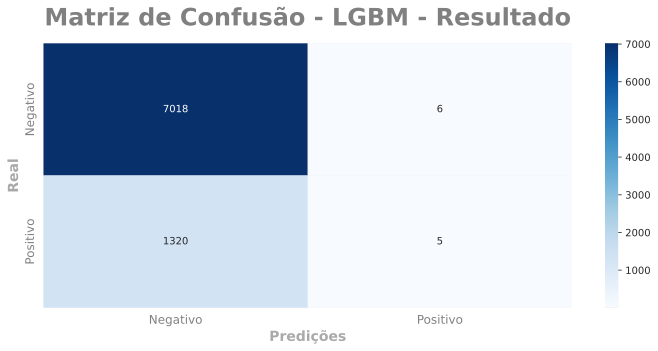

In [ ]:
# 59 - Matriz de confusão para a base de teste
plot_matriz_confusao_final(y_test, y_pred_final, "LGBM")

### Concluindo

#### * **Resultado** - foi muito satisfatório o resultado final de **84% de precisão** para os clientes que foram corretamente avaliados como **baixo risco**, quando utilizada a métrica **f1-score** e o balanceamento **smote**. A acurácia geral do modelo também foi bem com os mesmos **84%**. Contudo, para a classe de **alto risco**, o modelo acertou **apenas 45%**, e isso é preocupante. A título de estratégias, chegamos a obter **92%** de acerto para **baixo risco**, mas somente **16% de alto risco** quando utilizado o balanceamento **rus (random under sampler)**. Como percebido, a base nitidamente aponta para um viés da classe **baixo risco** de crédito. Fica a sugestão para outros testes.

#### * **Base de dados** - a base veio do próprio **Nubank** que a disponibiliza para testes. São **45 mil** linhas e **43** colunas, dentre elas, a variável alvo, **target_default**.

#### * **EDA** - com dificuldades reais, tivemos um intenso trabalho durante a fase de **exploração e tratamento** dos dados, desde correção dos tipos de dados (**object** em **float**), tratamento de valores **missing**, **mínimos negativos**, e dados **desbalanceados**, além da própria **padronização** e **encoding** já na fase da construção dos modelos de **machine learning**, e exclusão das colunas que de fato não trariam observações assertivas para nossa finalidade. Já para as colunas utilizadas, preenchimento dos valores **missing** com **mediana** para colunas **numéricas** e **moda** para colunas **categóricas**.

#### * **Algoritmos** - a escolha dos modelos ocorreu de modo parcial, ou seja, por escolha própria, buscando **3** modelos de **classificação**, sendo eles **XGBoost, SGD e LightGBM**.

#### * **Grid Search** - foi utilizada a técnica de escolha dos **melhores parâmetros**, para o algoritmo com a melhor resposta para a métrica  **f1-score**, no caso, **LightGBM**.

#### * **Parâmetros** - Observação interessante, é a de que **houve melhora** significativa após os ajustes nos parâmetros do algoritmo, principalmente se comparado aos valores de **treino**, onde normalmente são melhores. Apesar de tal melhora, quando olhamos para a classe de **alto risco**, como já mencionado, a resposta do **melhor modelo** ainda deixa a desejar.

#### * **Síntese** - Apesar de alguns **dados técnicos** trata-se de uma **análise inicial** focada na identificação do acerto na **probabilidade de adimplência** por parte de um **cliente em potencial** em seu primeiro contato com a empresa para obtenção de seu **cartão de crédito**. No caso, acerto de **84%**. Vale a experiência com **outros algoritmos** e seus parâmetros, ou ainda, atuar com tratamentos diferentes dos realizados. O mercado financeiro certamente agradecerá.

#### Muito obrigado pela leitura. Caso tenha interesse em analisar outros projetos fique à vontade acessando diretamente meu [GitHub](https://github.com/wallacecarlis/data_science), [Medium](https://wallacecarlis.medium.com/), e meu [Site](https://www.wallacecarlis.com/). Todo feedback será bem-vindo, abs!